In [2]:
#!/usr/bin/env python
# coding: utf-8

"""
By: Connor S. Murray
  - Performs differential gene expression on raw RNA-seq data with DESeq2!
"""
# Load Libraries
import argparse
import sys
import os
import math
import pandas as pd
import numpy as np
import re
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data
import matplotlib.pyplot as plt
import seaborn as sns

# Arguments from command line
def parse_arguments():
    parser = argparse.ArgumentParser(description="Differential gene expression analysis with DEseq2.")
    parser.add_argument("--metadata", required=False, 
                        default="/standard/vol185/cphg_Manichaikul/users/csm6hg/metadata/metadata_10_17_2024_CSM.txt",
                        help="Path to metadata file (must include SAMPLE_ID_TOR, Affected_NF).")
    parser.add_argument("--gene_counts", required=False, 
                        default="/standard/vol185/TOPMed/TOPCHef/82214/topmed-dcc/exchange/phs002038_TOPMed_TOPCHeF/Omics/RNASeq/release3/TOPMed_Taylor_P4.RNASeQCv2.3.6_gene_reads.gct.gz",
                        help="Raw gene counts file")
    parser.add_argument("--gtf", required=False, 
                        default="/standard/vol185/cphg_Manichaikul/users/csm6hg/genome_files/gencode.v34.GRCh38.ERCC.genes.collapsed.gtf", 
                        help="Path to GTF bed file (e.g., gencode.v34...).")
    return parser.parse_args()

# TESTING 
#metadata="/standard/vol185/cphg_Manichaikul/users/csm6hg/metadata/metadata_10_17_2024_CSM.txt";gene_counts="/standard/vol185/TOPMed/TOPCHef/82214/topmed-dcc/exchange/phs002038_TOPMed_TOPCHeF/Omics/RNASeq/release3/TOPMed_Taylor_P4.RNASeQCv2.3.6_gene_reads.gct.gz";gtf="/standard/vol185/cphg_Manichaikul/users/csm6hg/genome_files/gencode.v34.GRCh38.ERCC.genes.collapsed.gtf"

# Function to extract gene_id from the attributes field using regex
def extract_gene_info(attr_str):
    m1 = re.search(r'gene_id "([^"]+)"', attr_str)
    m2 = re.search(r'gene_name "([^"]+)"', attr_str)
    gene_id = m1.group(1) if m1 else None
    gene_name = m2.group(1) if m2 else None
    # Remove trailing version information: a dot followed by one or more digits at the end
    gene = re.sub(r"\.[0-9]+$", "", gene_id) if gene_id else None
    return pd.Series([gene_id, gene, gene_name], index=["gene_id", "gene", "common_gene"])

# Define the column names for a standard GTF file
gtf_columns = ["chrom", "source", "feature", "start", "end", 
               "score", "strand", "frame", "attribute"]

# Read the GTF file
df = pd.read_csv(gtf, sep="\t", comment="#", header=None, names=gtf_columns)

# Optionally, filter the DataFrame to only include gene-level annotations
genes_df = df[df["feature"] == "gene"].copy()

# Extract gene_id from the attribute column
genes_df[["gene_id", "gene","common_gene"]] = genes_df["attribute"].apply(extract_gene_info)

# Select only the columns of interest
result = genes_df[["chrom", "start", "end", "gene_id", "gene", "common_gene"]]
print(result.head())

# Read in metadata
meta = pd.read_csv(metadata, sep="\t", index_col="SAMPLE_ID_TOR")
print(meta.head())

if "TOR238072" in meta.index:
        meta.drop("TOR238072", inplace=True)

   chrom  start    end            gene_id             gene  common_gene
0   chr1  11869  14409  ENSG00000223972.5  ENSG00000223972      DDX11L1
6   chr1  14404  29570  ENSG00000227232.5  ENSG00000227232       WASH7P
19  chr1  17369  17436  ENSG00000278267.1  ENSG00000278267    MIR6859-1
22  chr1  29554  31109  ENSG00000243485.5  ENSG00000243485  MIR1302-2HG
27  chr1  30366  30503  ENSG00000284332.1  ENSG00000284332    MIR1302-2
              SAMPLE_ID_NWD Adult_Peds Affected_NF    HB# Participant_ID  \
SAMPLE_ID_TOR                                                              
TOR803269         NWD470364      Adult    Affected  C0004         DN0001   
TOR795199         NWD712162      Adult    Affected  C0012         DN0002   
TOR480443         NWD219667      Adult    Affected  C0037         DN0003   
TOR487285         NWD903947      Adult    Affected  C0044         DN0004   
TOR565416         NWD552965      Adult    Affected  C0045         DN0005   

              Gender  Body_Surface_

In [3]:
# Read in raw gene count matrix
gene_count = pd.read_table(
    gene_counts,
    compression="gzip",
    skiprows=2,
    index_col="Name")
print(f"Original gene_count shape: {gene_count.shape}")

# Ensure columns are string
gene_count.columns = gene_count.columns.astype(str)

# Align with meta
common_samples = meta.index.intersection(gene_count.columns)
print(f"Number of common samples: {len(common_samples)}")

gene_count = gene_count.loc[:, common_samples]
print(f"Filt. gene_count shape: {gene_count.shape}")
print(gene_count.head())

# Extract pre-filtered gene list
genes_list_filt = pd.read_csv("../output/rna/norm_medrat.tsv", sep="\t")
genes_list = genes_list_filt.filter(like='ENSG').columns
gene_count = gene_count[gene_count.index.isin(genes_list)]
print(f"Filt. gene_count shape: {gene_count.shape}")

# Extract pre-filtered sample list
samples = pd.read_csv("../output/eqtl/topchef_samples_1_15_25.txt", header=None, names=["SAMPLE_ID_NWD"])

Original gene_count shape: (58103, 777)
Number of common samples: 592
Filt. gene_count shape: (58103, 592)
                   TOR803269  TOR795199  TOR480443  TOR487285  TOR565416  \
Name                                                                       
ENSG00000223972.5          0          1          1          1          0   
ENSG00000227232.5         35        115         78         63         81   
ENSG00000278267.1          0          0          0          0          0   
ENSG00000243485.5          0          3          1          0          0   
ENSG00000284332.1          0          1          0          0          0   

                   TOR800584  TOR204073  TOR194372  TOR303522  TOR992637  ...  \
Name                                                                      ...   
ENSG00000223972.5          0          0          1          1          0  ...   
ENSG00000227232.5         53        147         34         94        112  ...   
ENSG00000278267.1          0        

In [4]:
gene_countsi = gene_count.T
meta_re = meta.rename_axis('Name')

# Convert the SAMPLE_ID_NWD column to a list
sample_ids = samples["SAMPLE_ID_NWD"].tolist()

# Filter metadata rows where SAMPLE_ID_NWD is in the sample_ids list
meta_re = meta_re[meta_re["SAMPLE_ID_NWD"].isin(sample_ids)]
meta_re = meta_re[meta_re["diagnosis_simple"].isin(["IDCM", "Non-Failing"])] # Restrict to just DCM vs Control
design_columns = ['diagnosis_simple', 'Age_at_collection']
meta_re = meta_re.dropna(subset=design_columns)
gene_countsii = gene_countsi[gene_countsi.index.isin(meta_re.index)]

print(f"Gene count matrix for DESeq2: {gene_countsii.shape}")

# Make DDS object
inference = DefaultInference(n_cpus=4)
dds = DeseqDataSet(counts=gene_countsii, 
                   metadata=meta_re, 
                   design_factors=['diagnosis_simple', 'Age_at_collection', 'Gender'],
                   refit_cooks=True,
                   inference=inference,)

# Normalization
dds.fit_size_factors()
norm_counts = pd.DataFrame(dds.layers["normed_counts"])
norm_counts.index = gene_countsii.index
norm_counts.columns = gene_countsii.columns
print(f"Normalized count matrix shape: {norm_counts.shape}")

Gene count matrix for DESeq2: (290, 19833)
Normalized count matrix shape: (290, 19833)


/tmp/ipykernel_941654/59380230.py:18: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(counts=gene_countsii,
Fitting size factors...
... done in 0.17 seconds.



In [5]:
# Run differential expression analysis (this takes a couple of mins)
dds.deseq2()

Fitting size factors...
... done in 0.17 seconds.

Fitting dispersions...
... done in 57.65 seconds.

Fitting dispersion trend curve...
... done in 0.37 seconds.

Fitting MAP dispersions...
... done in 63.83 seconds.

Fitting LFCs...
... done in 56.67 seconds.

Calculating cook's distance...
... done in 0.33 seconds.

Replacing 3407 outlier genes.

Fitting dispersions...
... done in 6.98 seconds.

Fitting MAP dispersions...
... done in 7.86 seconds.

Fitting LFCs...
... done in 13.95 seconds.



In [6]:
print(dds)
#print(meta["diagnosis_simple"].value_counts())

# Contrast groups 
stat_dcm = DeseqStats(dds, contrast = ('diagnosis-simple', 'IDCM', 'Non-Failing'), alpha=0.05)
#stat_icm = DeseqStats(dds, contrast = ('diagnosis-simple', 'ICM', 'Non-Failing'), alpha=0.05)
stat_dcm.summary()

AnnData object with n_obs × n_vars = 290 × 19833
    obs: 'SAMPLE_ID_NWD', 'Adult_Peds', 'Affected_NF', 'HB#', 'Participant_ID', 'Gender', 'Body_Surface_Area', 'Year_of_Transplant', 'Age-at-collection', 'Race', 'Ethnicity', 'Diagnosis', 'HISTOLOGICAL_TYPE', 'IS_TUMOR', 'CONSENT', 'BODY_SITE', 'Primary_biosample_type', 'UBERON_ID', 'UBERON_Term', 'Collection_year', 'Biosample_affection_status', 'Analyte_isolation_lab', 'ANALYTE_TYPE', 'Sample_container_ID', 'Sample_well_ID', 'Assay_lab', 'Mapping_Rate', 'Total_Reads', 'diagnosis-simple'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'norme

Running Wald tests...


Log2 fold change & Wald test p-value: diagnosis-simple IDCM vs Non-Failing
                        baseMean  log2FoldChange     lfcSE      stat  \
Name                                                                   
ENSG00000240361.2   5.797382e+00        0.144011  0.136308  1.056511   
ENSG00000186092.6   1.531777e+01        0.093130  0.108650  0.857153   
ENSG00000228463.10  6.395426e+01        0.248868  0.159086  1.564364   
ENSG00000237094.12  1.760178e+01        0.570770  0.159007  3.589587   
ENSG00000230021.10  5.567044e+00        0.600619  0.172529  3.481266   
...                          ...             ...       ...       ...   
ENSG00000212907.2   2.667144e+05        0.299631  0.134737  2.223817   
ENSG00000198886.2   2.356392e+06       -0.019088  0.061158 -0.312115   
ENSG00000198786.2   6.595804e+05        0.538188  0.104797  5.135541   
ENSG00000198695.2   2.067188e+04        0.010647  0.096990  0.109772   
ENSG00000198727.2   1.296110e+06       -0.186316  0.066349 -2

... done in 27.40 seconds.



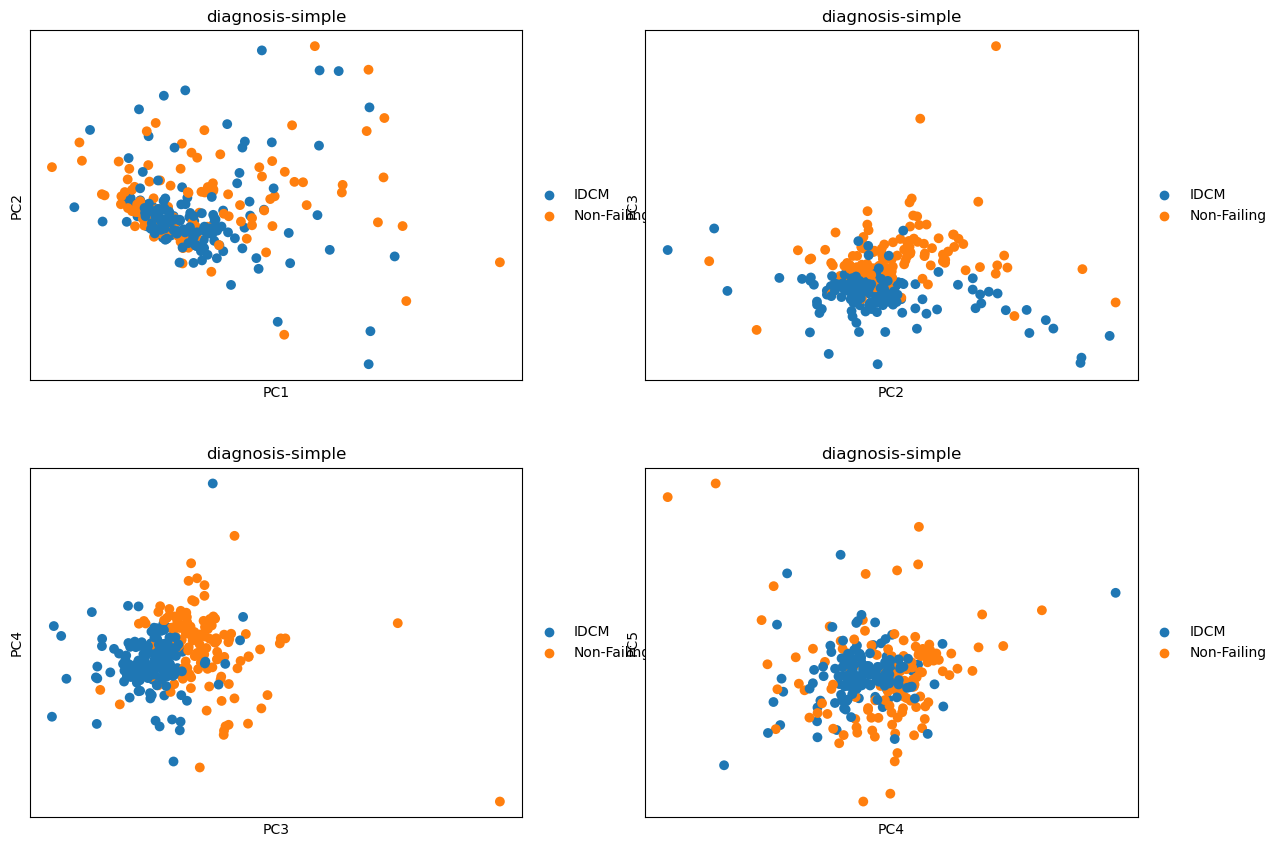

In [7]:
import scanpy as sc
sc.tl.pca(dds)
sc.pl.pca(dds, 
          groups=["Non-Failing", "IDCM"], 
          color = 'diagnosis-simple', 
          ncols=2,
          size = 200, 
          components=['1,2', '2,3', '3,4', '4,5'])

          baseMean  log2FoldChange     lfcSE      stat        pvalue  \
219.0  1737.906232       -0.706397  0.134435 -5.254575  1.483663e-07   
344.0    14.336267        1.757574  0.234642  7.490438  6.864396e-14   
429.0   102.729582        0.898058  0.152149  5.902505  3.580237e-09   
NaN     819.000063       -0.701788  0.168839 -4.156544  3.230985e-05   
NaN      11.264682       -0.635717  0.156976 -4.049784  5.126489e-05   

               padj chrom     start       end             gene_id  \
219.0  6.472831e-07  chr1  632757.0  633438.0   ENSG00000229344.1   
344.0  8.372790e-13  chr1  916870.0  919692.0   ENSG00000223764.2   
429.0  2.056586e-08  chr1  995966.0  998051.0   ENSG00000272512.1   
NaN    9.265489e-05   NaN       NaN       NaN   ENSG00000187608.9   
NaN    1.416068e-04   NaN       NaN       NaN  ENSG00000162571.13   

                  gene common_gene  
219.0  ENSG00000229344    MTCO2P12  
344.0  ENSG00000223764   LINC02593  
429.0  ENSG00000272512  AL645608.7  
NaN 

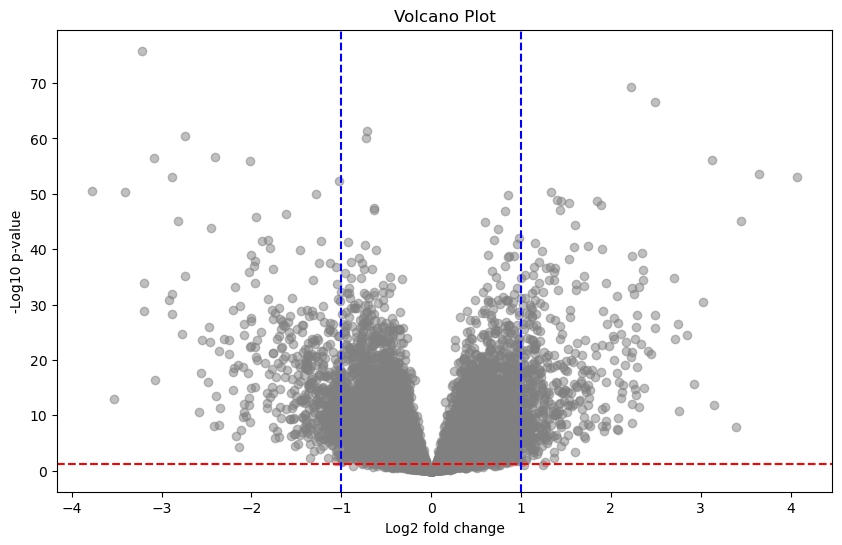

In [8]:
# Extract significant genes
res = stat_dcm.results_df
res = res.merge(result, left_index=True, right_on="gene_id", how='left')
res = res[res.baseMean >= 10]
res.to_csv('/standard/dard/vol185/cphg_Manichaikul/users/csm6hg/nextflow_dna/output/dge/sig_dge_DCM.csv', index=True)
sigs = res[(res.padj < 0.05) & (abs(res.log2FoldChange) > math.log2(1.5))]
print(sigs.head())

# Plot Volcano plot
plt.figure(figsize=(10, 6))
plt.scatter(res['log2FoldChange'], -np.log10(res['pvalue']), c='grey', alpha=0.5)
plt.axhline(-np.log10(0.05), color='red', linestyle='--')
plt.axvline(1, color='blue', linestyle='--')
plt.axvline(-1, color='blue', linestyle='--')
plt.xlabel('Log2 fold change')
plt.ylabel('-Log10 p-value')
plt.title('Volcano Plot')
plt.show()